In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities
from PIL import Image
seaborn.set()

In [27]:
def recall(
    base_embeddings, 
    lookup_embeddings,
    lookup_labels, 
    k
):
    '''
    For each base embedding in base_embeddings,
    compute top k recall as an absolute number
    (the number of ground truth positives in the lookup_embeddings
    that are in the top k)
    lookup_labels must be an array of 1's and 0's indicating the ground truth
    for the lookup set (1 = positive, 0 = negative)
    '''
    dist = pairwise_distances(
        base_embeddings,
        lookup_embeddings
    )
    return np.array([np.sum(np.array(lookup_labels)[np.argsort(d)][:k]) for d in dist])

In [49]:
path_to_adversarial = "/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5"
path_to_clean = "/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5"

epsilons = [0.02, 0.04, 0.06, 0.08, 0.1]

id2imnames = read_sampled_identities("../sampled_identities.txt")
identities = id2imnames.keys()

positive = []
negative_clean = []
negative_adv = {eps: [] for eps in epsilons}
ks = [1, 5, 10, 100, 1000]
top_k_recall = {k: {eps: [] for eps in epsilons} for k in ks}
num_available = {k: {eps: [] for eps in epsilons} for k in ks}

for adversarial_target in identities:
    clean_embeddings = []
    mod_embeddings = []
    adv = {eps: [] for eps in epsilons}
    
    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        clean_embeddings.extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        # the identity that was modified for the adversarial
        with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
            mod_embeddings.extend(f["embeddings"][:])

        for indx, epsilon in enumerate(epsilons):
            with h5py.File(path_to_adversarial.format(
                target=adversarial_target,
                true=modified_identity,
                epsilon=epsilon
            ), "r") as f:
                adv[epsilon].extend(f["embeddings"][:])

    positive.extend(
        pairwise_distances(
            clean_embeddings, 
            clean_embeddings)[np.tril_indices(len(clean_embeddings), -1)].flatten()
    )
    negative_clean.extend(
        pairwise_distances(
            clean_embeddings, 
            mod_embeddings).flatten()
    )
    for indx, epsilon in enumerate(epsilons):
        negative_adv[epsilon].extend(
            pairwise_distances(clean_embeddings, adv[epsilon]).flatten()
        )
        
    for k in ks:
        for eps in epsilons:
            top_k_recall[k][eps] = recall(
                clean_embeddings, 
                adv[eps],
                [1 for _ in range(len(clean_embeddings))] + [0 for _ in range(len(adv[eps]))],
                k
            )
            num_available[k][eps] = min((len(adv[eps]), k))

In [50]:
import pprint
pp = pprint.PrettyPrinter()

pp.pprint(num_available)

{1: {0.02: 1, 0.04: 1, 0.06: 1, 0.08: 1, 0.1: 1},
 5: {0.02: 5, 0.04: 5, 0.06: 5, 0.08: 5, 0.1: 5},
 10: {0.02: 10, 0.04: 10, 0.06: 10, 0.08: 10, 0.1: 10},
 100: {0.02: 100, 0.04: 100, 0.06: 100, 0.08: 100, 0.1: 100},
 1000: {0.02: 900, 0.04: 900, 0.06: 900, 0.08: 900, 0.1: 900}}


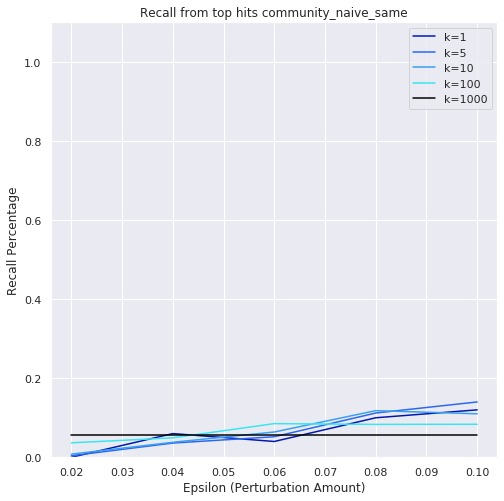

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

mean_top_k_recall = {k: {eps: -1.0 for eps in epsilons} for k in ks}

colors=['#0017ad',
        '#2d67ed',
        '#37a0f0',
        '#37e6f0',
        '#000000'
       ]

for indx, k in enumerate(top_k_recall.keys()):
    epsilons = top_k_recall[k].keys()
    recall_to_plot = []
    for eps in epsilons:
        recall_percent = np.array(top_k_recall[k][eps]) / float(num_available[k][eps])
        mean_recall = np.mean(recall_percent)
        mean_top_k_recall[k][eps] = mean_recall
        recall_to_plot.append(mean_recall)
        
    ax.plot(
        list(epsilons),
        recall_to_plot,
        label="k={}".format(k),
        color=colors[indx],
    )

ax.set_ylabel("Recall Percentage")
ax.set_xlabel("Epsilon (Perturbation Amount)")
ax.set_title("Recall from top hits community_naive_same")
ax.set_ylim([0.0, 1.1])
ax.legend()
plt.show()


In [42]:
print(epsilons)

dict_keys([0.02, 0.04, 0.06, 0.08, 0.1])


In [43]:
print(recall_to_plot)

[0.0, 0.06, 0.04, 0.1, 0.12]
